## Accessing Sentinel-2 L2A data with the Planetary Computer STAC API

The [Sentinel-2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) program provides global imagery in thirteen spectral bands at 10m-60m resolution and a revisit time of approximately five days.  This dataset represents the global Sentinel-2 archive, from 2016 to the present, processed to L2A (bottom-of-atmosphere) using [Sen2Cor](https://step.esa.int/main/snap-supported-plugins/sen2cor/) and converted to [cloud-optimized GeoTIFF](https://www.cogeo.org/) format.  The digital elevation model used for terrain correction was [Planet DEM 30](https://planetobserver.com/global-elevation-data/).

This notebook demonstrates the use of the Planetary Computer STAC API to query for Sentinel-2 tiles.

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.
The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. The Planetary Computer Hub is pre-configured to use your API key.

In [1]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)

### Choose a region and time of interest

This area is near Jonah Bay, Alaska.

In [2]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-148.56536865234375, 60.80072385643073],
            [-147.44338989257812, 60.80072385643073],
            [-147.44338989257812, 61.18363894915102],
            [-148.56536865234375, 61.18363894915102],
            [-148.56536865234375, 60.80072385643073],
        ]
    ],
}

Define the time range to filter images with. Here we use the summer of 2019.

In [3]:
time_of_interest = "2019-06-01/2019-08-01"

### Search the collection and choose an image to render

Use [pystac-client](https://github.com/stac-utils/pystac-client) to search for Sentinel 2 L2A data in this time range.

In [4]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

# Check how many items were returned
items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 5 Items


We can now work directly with the [PySTAC](https://github.com/stac-utils/pystac) Items returned by the API. Here we find the least cloudy of the bunch.

In [5]:
least_cloudy_item = sorted(items, key=lambda item: eo.ext(item).cloud_cover)[0]

print(
    f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()}"
    f" with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover"
)

Choosing S2B_MSIL2A_20190629T212529_R043_T06VVN_20201006T080531 from 2019-06-29 with 0.314306% cloud cover


Get the URL to the [Cloud Optimized GeoTIFF](https://www.cogeo.org/) image corresponding to the true color composite image.

In [6]:
asset_href = least_cloudy_item.assets["visual"].href

This HREF is a URL is the location of the asset data on [Azure Blob Storage](https://azure.microsoft.com/en-us/services/storage/blobs/). In order to read the data, we'll need to retrieve a [Shared Access Signature](https://docs.microsoft.com/en-us/azure/storage/common/storage-sas-overview) and supply it as a query parameter. These tokens are generated from the Planetary Computer [Data Access API](https://planetarycomputer.microsoft.com/api/sas/v1/docs).

We use the [planetary-computer](https://github.com/microsoft/planetary-computer-sdk-for-python) package to "sign" our asset HREF with a generated token:

In [7]:
signed_href = pc.sign(asset_href)

We can now use the HREF to read our data in any tools that can retrieve data from URLs via HTTP GET operations.

For example, here we use rasterio to render the image data over our area of interest:

### Render our AOI from this image

In [8]:
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp

import numpy as np
from PIL import Image

with rasterio.open(signed_href) as ds:
    aoi_bounds = features.bounds(area_of_interest)
    warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
    aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
    band_data = ds.read(window=aoi_window)

rasterio gives us data band-interleave format; transpose to pixel-interleave, and downscale the image data for plotting.

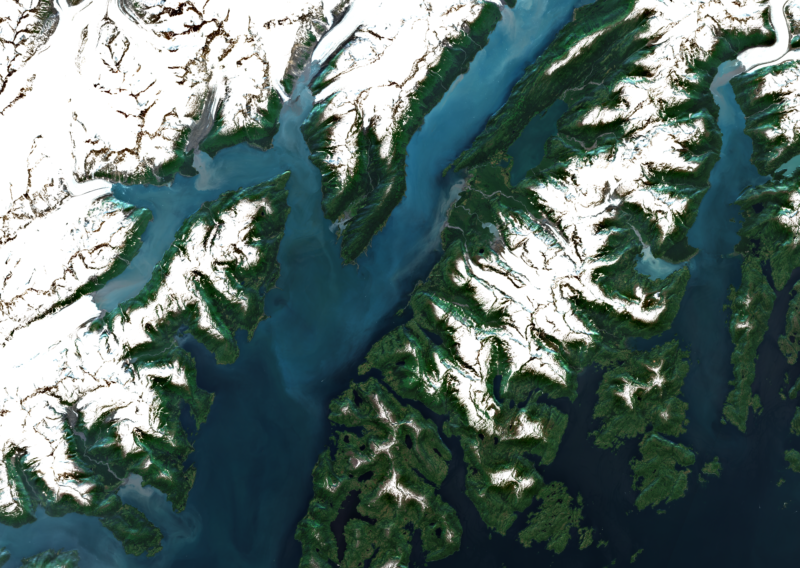

In [9]:
img = Image.fromarray(np.transpose(band_data, axes=[1, 2, 0]))
w = img.size[0]
h = img.size[1]
aspect = w / h
target_w = 800
target_h = (int)(target_w / aspect)
img.resize((target_w, target_h), Image.BILINEAR)